<a href="https://colab.research.google.com/github/Dicere/WB_Internship/blob/main/TreeClf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Implemented a leaf growth algorithm (similar to that of LigthGBM) on the leftmost branch

###Реализован алгоритм роста по листьям (примерно как у LigthGBM) по крайней левой ветке

In [3]:
import numpy as np
import pandas as pd
import random

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Реализация всех алгоритмов/data_banknote_authentication.txt', header=None)
df.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'target']
X, y = df.iloc[:,:4], df['target']

In [152]:
class MyTreeClf():
    def __init__(self, max_depth=5, min_samples_split=2,max_leafs=2):         
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_leafs = max_leafs
        self.leafs_cnt = 0
        self.a = {}
        self.depths_numb={}
        self.node_count = 0
        self.flag = 0
    def __str__(self):
        attributes = ', '.join(f"{key}={value}" for key, value in vars(self).items())
        return f"MyTreeClf class: {attributes}"
    def __repr__(self):
        attributes = ', '.join(f"{key}={value}" for key, value in vars(self).items())
        return f"MyTreeClf class: {attributes}"
    @staticmethod
    def entr(y):
      n = y.shape[0]
      one_count = np.count_nonzero(y == 1)
      zero_count =  np.count_nonzero(y == 0)
      if one_count == 0 or zero_count==0:
        return 0
      s=-((zero_count/n)*np.log2(zero_count/n)+(one_count/n)*np.log2(one_count/n))
      return s
      print(one_count,zero_count,n)

    def get_best_split(self,X,y):
      n_cols = X.shape[1]
      s0 = self.entr(y)
      ig_max=0
      col_name=""
      split_value=np.float()
      for i in range(n_cols):
        stroka = np.sort(X.iloc[:,i].unique())
        ig = 0
        for b in range(len(stroka)-1):
          split_val = (stroka[b]+stroka[b+1])/2
          idx_right = X[np.all([X.iloc[:,i] > split_val], axis=0)].index
          idx_left = X[np.all([X.iloc[:,i] <= split_val], axis=0)].index
          ig = s0 - ((len(idx_left)/len(y))*self.entr(y.loc[idx_left])) - ((len(idx_right)/len(y))*self.entr(y.loc[idx_right]))
          if ig > ig_max:
            ig_max=ig
            col_name=X.iloc[:,i].name
            split_value = split_val
      return col_name, split_value, ig_max

    def node_or_list(self, y,curr_depth):
      if y.shape[0] == 1:
        # print('1 семпл')
        return False
      elif np.count_nonzero(y == 1) == 0: 
        # print('Класса 1 нету')
        return False
      elif np.count_nonzero(y == 0)==0:
        # print('Класса 0 нету')
        return False
      elif self.max_depth ==curr_depth:
        # print('Макс глубина')
        return False
      elif self.max_leafs <=2:
        # print('Меньше 1 листа быть не может')
        return False      
      elif self.min_samples_split >y.shape[0]:
        # print('Минимальное возможное количетсво элементов для разбиения')
        return False
      else:
        if self.node_count!=0:   
          return True


    def add_leaf(self,curr_depth,leaf_name,leaf):
          if curr_depth in self.a.keys():
            one = np.count_nonzero(y.loc[leaf] == 1)
            chance = one/len(leaf)
            self.a[curr_depth].append([chance])
          else:
            one = np.count_nonzero(y.loc[leaf] == 1)
            chance = one/len(leaf)
            self.a[curr_depth] = []
            self.a[curr_depth].append([chance])
          self.leafs_cnt += 1

    def iter_for_feature(self,X,y,curr_depth=0):

        col_name, split_val, ig = self.get_best_split(X,y)
       
        leaf_left = X[np.all([X.loc[:,col_name] <= split_val], axis=0)].index
        leaf_right = X[np.all([X.loc[:,col_name] > split_val], axis=0)].index

        if curr_depth in self.a.keys():
          if curr_depth in self.depths_numb.keys():
            self.a[curr_depth].append([col_name, split_val,self.depths_numb[curr_depth],self.depths_numb[curr_depth]+1])
            self.depths_numb[curr_depth] +=2
          else:
            self.depths_numb[curr_depth] = 0
            self.a[curr_depth].append([col_name, split_val,self.depths_numb[curr_depth],self.depths_numb[curr_depth]+1])
            self.depths_numb[curr_depth] +=2
        else:
          self.depths_numb[curr_depth] = 0
          self.a[curr_depth] = []
          self.a[curr_depth].append([col_name, split_val,self.depths_numb[curr_depth],self.depths_numb[curr_depth]+1])
          self.depths_numb[curr_depth] +=2
        
        curr_depth +=1    
        if self.node_or_list(y.loc[leaf_left],curr_depth):
          self.node_count-=1
          self.iter_for_feature(X.loc[leaf_left],y.loc[leaf_left],curr_depth)
        else:
          self.add_leaf(curr_depth,"leaf_left",leaf_left)

        if self.node_or_list(y.loc[leaf_right],curr_depth):

          self.node_count-=1
          self.iter_for_feature(X.loc[leaf_right],y.loc[leaf_right],curr_depth)
        else:
          self.add_leaf(curr_depth,"leaf_right",leaf_right)

        

    def fit(self, X_fit: pd.DataFrame, y_fit: pd.Series):
      X = X_fit.copy()
      y = y_fit.copy()
      self.node_count = self.max_leafs-2
      self.iter_for_feature(X,y)
      return self.a

    def pred(self,x,i,c):
      if len(self.a[i][c]) != 1:
        uslovie = self.a[i][c][1]
        column = self.a[i][c][0] 
        idx_left_leaf=self.a[i][c][2]
        idx_right_leaf= self.a[i][c][3]
        if x[column] <= uslovie:
          i+=1            
          return self.pred(x,i,idx_left_leaf)
        else:
          i+=1
          return self.pred(x,i,idx_right_leaf)
      else:
        return self.a[i][c][-1]

    def predict(self, X_test: pd.DataFrame):
        X = X_test.copy()
        y_pred_vec = X.apply(lambda x: self.pred(x,0,0),axis=1)
        return np.sum(y_pred_vec)




In [153]:
instance = MyTreeClf(max_depth=7, min_samples_split=2,max_leafs=40)

In [154]:
a = instance.fit(X,y)

<ipython-input-152-02cdc28b6ffd>:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  split_value=np.float()


In [155]:
instance.predict(X)

610.0

### Visualization

In [156]:
import graphviz

class TreeNode:
    def __init__(self, value, left=None, right=None):
        self.is_leaf = len(value) == 1  # Лист содержит только один элемент
        self.value = value
        self.left = left
        self.right = right

def build_tree(tree_dict):
    nodes = {0: [TreeNode(tree_dict[0][0])]}

    for depth in range(1, max(tree_dict.keys())+1):
        nodes[depth] = []
        i = 0
        while i < len(tree_dict[depth]):
            for parent_node in nodes[depth-1]:
                if parent_node.is_leaf:
                    # Если родитель является листом, он не может иметь детей, поэтому пропускаем его.
                    continue
                left = TreeNode(tree_dict[depth][i])
                right = TreeNode(tree_dict[depth][i+1]) if i+1 < len(tree_dict[depth]) else None
                parent_node.left = left
                parent_node.right = right
                nodes[depth].extend([left, right])
                i += 2  # Переходим к следующей паре узлов на текущей глубине.
                if i >= len(tree_dict[depth]):  # Прерываем цикл, если больше нет узлов.
                    break
    return nodes[0][0]  # Возвращаем корень дерева

def add_edges(graph, node, parent_name=""):
    if node is not None:
        node_name = parent_name + str(node.value)
        graph.node(node_name, label=str(node.value))
        if parent_name:
            graph.edge(parent_name, node_name)
        add_edges(graph, node.left, node_name)
        add_edges(graph, node.right, node_name)

def visualize_tree(root):
    dot = graphviz.Digraph()
    add_edges(dot, root)
    return dot


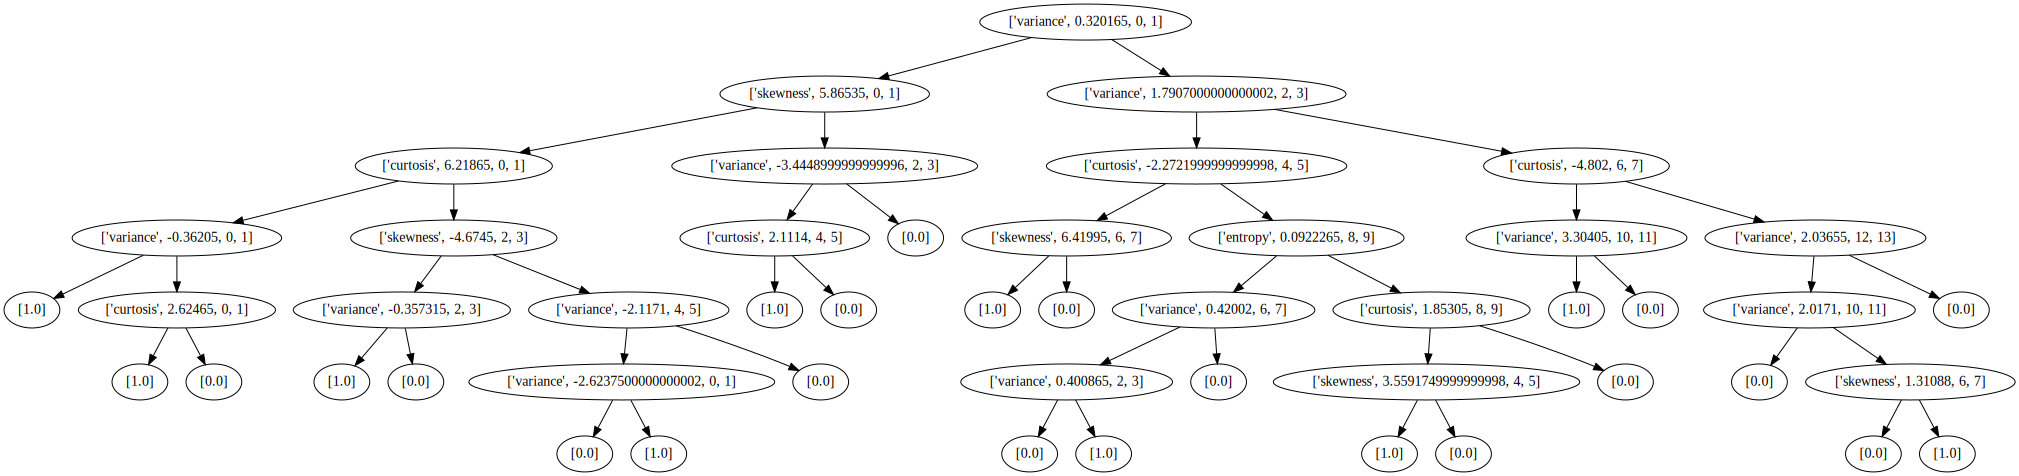

In [157]:
tree_root = build_tree(a)
dot = visualize_tree(tree_root)
dot

In [92]:
a[]

{0: [['col_0', -0.1, 0, 1]],
 1: [['col_3', 1.51, 0, 1], ['col_2', -0.235, 2, 3]],
 2: [[1.0], ['col_1', 1.445, 2, 3], [1.0], [0.0]],
 3: [['col_2', -0.65, 0, 1], [1.0]],
 4: [['col_3', 1.935, 0, 1], ['col_4', -0.07, 2, 3]],
 5: [[1.0], [0.0], [0.14285714285714285], [1.0]]}

In [122]:
def predict_row(node, row):
    if node.is_leaf:
        # Если достигнут лист, возвращаем вероятность для первого класса
        return node.value[0]
    # print(node.value[1])
    # print(row)

    # # Получаем индекс фичи, по которой делается разделение
    # feature_index = node.value[0]
    
    # # Получаем значение фичи из строки
    # feature_value = row[feature_index]
    
    if row[node.value[0]] <= node.value[1]:
        # print(node.left)
        return predict_row(node.left, row)  # Рекурсивно вызываем для левого поддерева
    else:
        # print(node.right)
        return predict_row(node.right, row)  # Рекурсивно вызываем для правого поддерева

def predict(tree, dataframe):
    predictions = []
    for _, row in dataframe.iterrows():
        prediction = predict_row(tree, row)
        predictions.append(prediction)
    return predictions

# Пример использования
# Предполагается, что у вас уже есть построенное дерево и входной датафрейм с фичами

# Выполняем предсказание
predictions = predict(tree_root, X)
sum(predictions)
# Выводим предсказания

610.0000000000014